In [1]:
# System
import os
import sys
import inspect
import tabulate
import time

# Data processing
import numpy as np
import math as m

# Results presentation
from tqdm import tqdm as tqdm
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt

# NN related stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# from torch.autograd import Variable

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import data
import models
import utils
import correlation
import regularization


%matplotlib inline

In [2]:
class GlobalArguments():
    
    def __init__(self):
        self.model       = 'vgg16_bn'
        self.dataset     = 'CIFAR100'
        self.data_path   = '../Data/'
        self.batch_size  = 128
        self.num_workers = 4
        self.transform   = 'VGG'
        self.use_test    = True
        self.models_path = '../Checkpoints/'
        self.n_models    = 21
args = GlobalArguments()

In [3]:
loaders, num_classes = data.loaders(
    args.dataset,
    args.data_path,
    args.batch_size,
    args.num_workers,
    args.transform,
    args.use_test,
    shuffle_train=False
)

Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


In [4]:
architecture = getattr(models, args.model)

In [7]:
# models_list_ind = []
# indicies = np.arange(args.n_models)
# # np.random.shuffle(indicies[1:-1])

# for i in tqdm(indicies):
#     model = architecture.base(num_classes=num_classes, **architecture.kwargs)
#     checkpoint = torch.load(
#         '../Checkpoints/VGG16BN/CIFAR100_STEP200/' + str(i) + '/checkpoint-200.pt',
#         map_location=torch.device('cpu'))
# #     print (model)
#     model.load_state_dict(checkpoint['model_state'])
#     models_list_ind.append(model)

100%|██████████| 21/21 [02:00<00:00,  5.75s/it]


In [20]:
models_list_fge = []
# indicies = range (690, 1011, 20)
indicies = list(range (219, 619, 20))
indicies.insert(0, 200)

for i in tqdm(indicies):
    model = architecture.base(num_classes=num_classes, **architecture.kwargs)
    checkpoint = torch.load('../Checkpoints/FGE/CIFAR100/VGG16BN/common/0/fge-' + str(i) + '.pt', map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state'])
    models_list_fge.append(model)

100%|██████████| 21/21 [02:02<00:00,  5.84s/it]


In [21]:
# models_list_fge_2 = []
# # indicies = range (690, 1011, 20)
# indicies = range (219, 749, 20)

# for i in tqdm(indicies):
#     model = architecture.base(num_classes=num_classes, **architecture.kwargs)
#     checkpoint = torch.load('./Checkpoints/FGE/new/VGG16BN/weight_adaboost/coef0.2_nocorrect_0//fge-' + str(i) + '.pt', map_location=torch.device('cpu'))
# #     print (model)
#     model.load_state_dict(checkpoint['model_state'])
#     models_list_fge_2.append(model)

In [22]:
# len(models_list_fge)
# len(models_list_fge_2)


In [23]:
def ensemble_models (model_list, dataloader, device=torch.device('cpu'), adjust_weight=False):
    with torch.no_grad():
        predictions = []
        target = []
        n_models = len(model_list)

        for _, labels in dataloader:
            target.append(labels.detach())
        target = torch.cat(target, dim=0)

        for iter in tqdm(range(len(model_list))):
            model_device = model_list[0].eval().to(device)
            predictions.append([])
            for input, _ in dataloader:
                input_device = input.to(device).detach()
                predictions[iter].append(model_device(input_device).detach().cpu())
                del input_device
            predictions[iter] = torch.cat(predictions[iter], dim=0)
            del model_device
            del model_list[0]

        sum_prediction = torch.zeros_like(predictions[0])
        acc_list = []
        ens_acc_list = []
        for prediction in tqdm(predictions):
            if adjust_weight:
                lr = regularization.adjust_boost_lr(dataloader, )
            else:
                lr = 1.
            sum_prediction += lr * prediction
            pred_labels     = prediction    .argmax(dim=1)
            ens_pred_labels = sum_prediction.argmax(dim=1)

            acc     = torch.eq(pred_labels    , target).sum().item() / len(target)
            ens_acc = torch.eq(ens_pred_labels, target).sum().item() / len(target)
            acc_list    .append(acc)
            ens_acc_list.append(ens_acc)
        
    return acc_list, ens_acc_list

In [24]:
# torch.cuda.memory_summary(device=torch.device('cuda:0'))
# torch.cuda.memory_snapshot()

In [25]:
# cor_matrix = correlation.cross_entropy_Nmodels (needed_models, loaders['test'], torch.device('cpu'))

In [26]:
# acc_list_ind, ens_acc_list_ind = ensemble_models(models_list_ind, loaders['test'], torch.device('cuda:0'))

In [27]:
acc_list_fge, ens_acc_list_fge = ensemble_models(models_list_fge, loaders['test'], torch.device('cuda:0'))

100%|██████████| 21/21 [00:00<00:00, 181.42it/s]


In [28]:
# acc_list_fge_2, ens_acc_list_fge_2 = ensemble_models(models_list_fge_2, loaders['test'], torch.device('cuda:0'))

In [102]:
def plot (y_mas, time, savefig=None):

    fig, ax = plt.subplots()
    for iter, y in enumerate(y_mas):
        ax.plot(time, y, label=str(iter), marker='o', mec='k', mfc=(0, 0, 0, 0))

    ax.set(xlabel='Number of models', ylabel='Accuracy',
           title='Ensembling methods comparison')
    ax.grid()

    if savefig is not None:
        fig.savefig(savefig, dpi=400)
    plt.legend()
    plt.show()

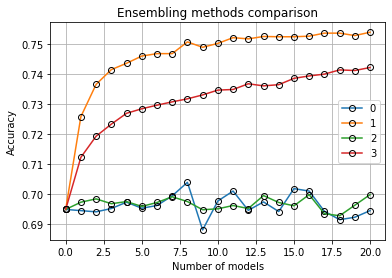

In [104]:
# plot ([acc_list_ind, acc_list_fge, ens_acc_list_ind, ens_acc_list_fge], np.arange(len(acc_list_ind)))
# plot ([ens_acc_list_fge], np.arange(len(acc_list_fge)))

plot (
    [acc_list_ind,
     ens_acc_list_ind,
     acc_list_fge,
     ens_acc_list_fge],
    np.arange(len(acc_list_fge)),
    savefig='figures/indepVSFGE')

# plot (
#     [ens_acc_list_ind,
#      ens_acc_list_fge],
#     np.arange(len(acc_list_fge)),
#     savefig='figures/indepVSFGE')

# plot (
#     [acc_list_ind,
#      ens_acc_list_ind],
#     np.arange(len(acc_list_ind)))

# plot (
#     [acc_list_fge,
#      ens_acc_list_fge],
#     np.arange(len(acc_list_ind)))